Episode:  0


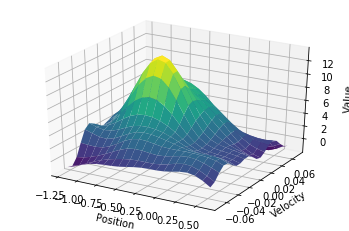

Episode:  100


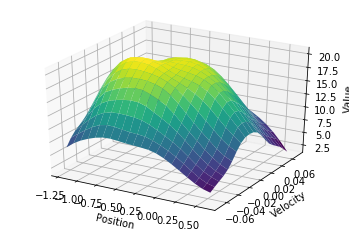

Episode:  200


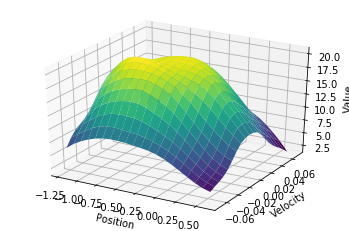

Episode:  300


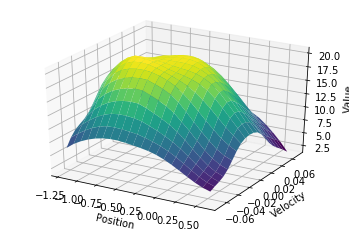

Episode:  400


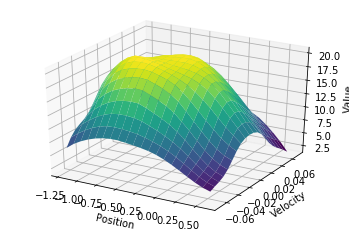

Episode:  500


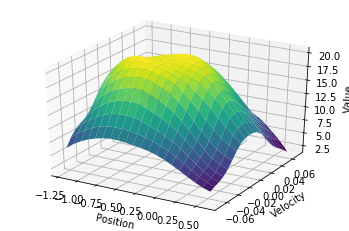

Episode:  600


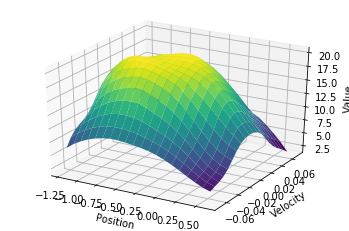

Episode:  700


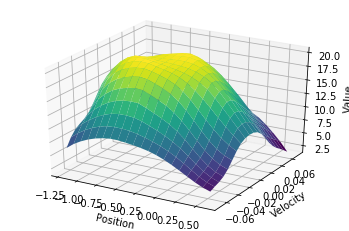

Episode:  800


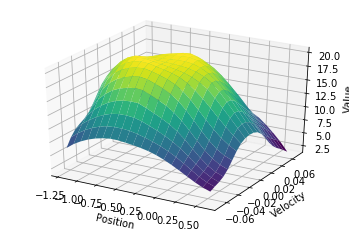

Episode:  900


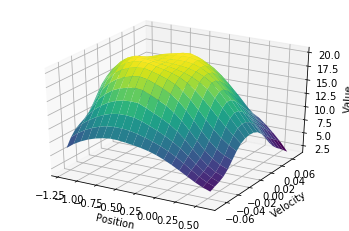

Final Q Values


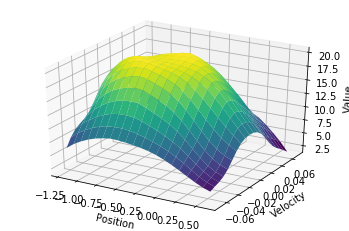

In [10]:
import matplotlib
import numpy as np
import gym
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from mpl_toolkits.mplot3d import Axes3D
import sklearn.pipeline
import sklearn.preprocessing

env = gym.make('MountainCar-v0')


numEpisodes = 1000
discountFactor = 0.95
alpha = 0.1
nA = env.action_space.n

w = np.zeros((nA,100))

epRewards = np.zeros(numEpisodes)

observation_examples = np.array([env.observation_space.sample() for x in range(1000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=25)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=25)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=25)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=25))
        ])

featurizer.fit(scaler.transform(observation_examples))

def featurize_state(state):
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized

def policy(state, weight, epsilon=0.1):
    A = np.ones(nA,dtype=float) * epsilon/nA
    best_action =  np.argmax([state.dot(w[a]) for a in range(nA)])
    A[best_action] += (1.0-epsilon)
    sample = np.random.choice(nA,p=A)
    return sample

def plot_cost_to_go_mountain_car(num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max([featurize_state(_).dot(w[a]) for a in range(nA)]), 2, np.dstack([X, Y]))
    
    ax = plt.axes(projection='3d')
    x = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                        cmap='viridis', edgecolor='none')

    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    
    plt.show()


for e in range(numEpisodes):

    state = env.reset()
    state = featurize_state(state)

    while True:
        action = policy(state,w)
        observation, reward, done, info = env.step(action)
        observation = featurize_state(observation)

        next_action = policy(observation,w)

        epRewards[e] += reward

        target = reward + discountFactor * observation.dot(w[next_action])
        td_error = state.dot(w[action]) - target

        dw = (td_error).dot(state)

        w[action] -= alpha * dw

        if done:
            if e%100 == 0:
                print("Episode: ", e)
                plt.figure()
                plot_cost_to_go_mountain_car()
                plt.show()
            break
        state = observation

print("Final Q Values")
plt.figure()
plot_cost_to_go_mountain_car()

env.close()